<a href="https://colab.research.google.com/github/felanbi/Projet-OC-Categoriser-automatiquement-des-questions/blob/main/P5_01_notebookexploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_queries = 'drive/MyDrive/data/'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display
import os
import nltk
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import FreqDist
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
import nltk 

nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sql_query = '''
SELECT
  Id,
  Title,
  Body,
  Tags
FROM 
  Posts
WHERE 
  Tags != ''
  and CreationDate >= '2020-01-01' 
  and Score > 0
  and ViewCount >= 100
  and AnswerCount > 0
'''

In [ ]:
data = pd.DataFrame()

print('Lecture des fichiers:\n')
for f in os.listdir(path_queries):
    if 'query' in f:
        print('Fichier en cours de chargement: ' + f)
        data = pd.concat([data,
                          pd.read_csv(path_queries + f, index_col = 0)])

data.columns = [col.lower() for col in data.columns]
data.head()

Lecture des fichiers:

Fichier en cours de chargement: query_2021_1.csv
Fichier en cours de chargement: query_2021_2.csv
Fichier en cours de chargement: query_2020_1.csv
Fichier en cours de chargement: query_2020_2.csv
Fichier en cours de chargement: query_2020_3.csv
Fichier en cours de chargement: query_2020_4.csv
Fichier en cours de chargement: query_2020_5.csv
Fichier en cours de chargement: query_2020_6.csv
Fichier en cours de chargement: query_2020_7.csv
Fichier en cours de chargement: query_2020_8.csv


,title,body,tags
Id,,,
65526399,Groovy script code to append xml node taking 1...,<p>Below code is working but taking 15+ hours ...,<javascript><xml><groovy><xml-parsing><sap-clo...
65526401,How do I make a class instance using user input?,<p>I am making a text based adventure game in ...,<python>
65526407,"How to remove Branding WHMCS Ver 8.1 ""Powered ...",<p>I am a newbie and this is the first time ev...,<php><jquery><css><templates><whmcs>
65526419,How can I construct my objects allocated throu...,<p>C++20 removed the <code>construct()</code> ...,<c++><std><c++20><allocator>
65526447,React Router v5.2 - Blocking route change with...,<p>My app has two pages: <code>Step1</code> an...,<javascript><reactjs><react-router><react-rout...


In [ ]:
df = data.copy()

df.tags = df.tags.map(lambda x: x[1:-1].replace('><', ' ').split())

tags_extended = [x for liste in df.tags for x in liste]
tags = set(tags_extended)

# top 20 tags
top_tags = [x[0] for x in FreqDist(tags_extended).most_common(20)]
df.tags = df.tags.map(lambda x: [t for t in x if t in top_tags])

df = df[df.tags.map(len) != 0]
df.head()

,title,body,tags
Id,,,
65526399,Groovy script code to append xml node taking 1...,<p>Below code is working but taking 15+ hours ...,[javascript]
65526401,How do I make a class instance using user input?,<p>I am making a text based adventure game in ...,[python]
65526407,"How to remove Branding WHMCS Ver 8.1 ""Powered ...",<p>I am a newbie and this is the first time ev...,"[php, css]"
65526419,How can I construct my objects allocated throu...,<p>C++20 removed the <code>construct()</code> ...,[c++]
65526447,React Router v5.2 - Blocking route change with...,<p>My app has two pages: <code>Step1</code> an...,"[javascript, reactjs]"


In [ ]:
def clean_text(text, tags):
    if text.beginswith("<p>") and text.endswith("<p>"):
      # Getting text from raw html file if it is
      from bs4 import BeautifulSoup
      soup = BeautifulSoup(text, 'html.parser')
      text = soup.get_text()
    
    # Lowering all words in text
    text = text.lower()
    
    # On sépare le texte pour ne garder que les tags et le texte sans les tags
    text_split = text.split()
    tags_in_text = [w for w in text_split if w in tags]
    text = [w for w in text_split if w not in tags]
    
    # Removing non letters (unless if word is not in tags) :
    text = ' '.join(text)
    text = re.sub('[^a-zA-Z]', ' ', text) 
        
    return text + ' '.join(tags_in_text) 

In [ ]:
df.title = df.title.map(lambda x: clean_text(x, top_tags))
df.body = df.body.map(lambda x: clean_text(x, top_tags)

df['post'] = df.title + df.body
df.drop(columns = ['title', 'body'], inplace = True)
df = df[['post', 'tags']]

df.head()

,post,tags
Id,,
65526399,groovy script code to append xml node taking ...,[javascript]
65526401,how do i make a class instance using user inpu...,[python]
65526407,how to remove branding whmcs ver powered ...,"[php, css]"
65526419,how can i construct my objects allocated throu...,[c++]
65526447,react router v blocking route change with...,"[javascript, reactjs]"


In [ ]:
def tokenizer(post, tags):

    from nltk.tokenize import word_tokenize

    tags_in_post = [tag for tag in post.split()]
    post = [w for w in post.split() if w not in tags]
    post = ' '.join(post)

    token = word_tokenize(post)

    return " ".join(token + tags_in_post)

df.post = df.post.map(lambda x: tokenizer(x, top_tags))
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,post,tags
Id,,
65526399,groovy script code to append xml node taking h...,[javascript]
65526401,how do i make a class instance using user inpu...,[python]
65526407,how to remove branding whmcs ver powered by wh...,"[php, css]"
65526419,how can i construct my objects allocated throu...,[c++]
65526447,react router v blocking route change with crea...,"[javascript, reactjs]"


In [ ]:
from nltk.stem import SnowballStemmer
from nltk import pos_tag

stemmer = SnowballStemmer("english")

def stem_text(x):
    return [stemmer.stem(w) for w in x.split()]

df.post = df.post.map(stem_text)

def remove_verbs(x):
    x = pos_tag(x)
  
    return [w[0] for w in x if w[1] not in {"VBD", "VB"}]

df.post = df.post.map(remove_verbs)

In [ ]:
from nltk.corpus import stopwords

stopwords_file = open(path_queries + "stopwords.txt")
stopwords = {x.replace("\n", "") for x in stopwords_file.readlines()}
stopwords.update(nltk_sw)

def remove_sw(x, tags, stopwords):
    text_tags = [w for w in x if w in tags]
    text = [w for w in x if w not in tags]
    text = [w for w in text if w not in stopwords]
    text.extend(text_tags)

    return text 

df.post = df.post.map(remove_sw)

In [ ]:
from nltk import FreqDist

word_corpus = [token for token_list in df.post.map(lambda x: x.split()) for token in token_list]
word_dist = FreqDist(word_corpus).most_common()
vocabulary = [x[0] for x in word_dist]
vocabulary[:10]

['data', 'error', 'id', 'name', 'code', 'app', 'value', 'div', 'user', 'type']

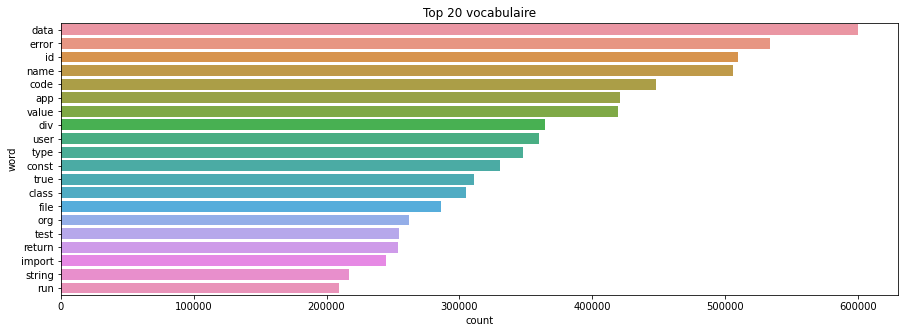

In [ ]:
top_20_words = word_dist[:20]
df_dist = pd.DataFrame(data = top_20_words,
                       columns = ["word", "count"])

plt.figure(figsize = (15, 5))
plt.title(f"Top 20 vocabulaire")
sns.barplot(data = df_dist,
            y = "word",
            x = "count")
plt.show()

In [ ]:
data = pd.read_pickle("drive/MyDrive/data/data_tokenized_sw_free_v2.pkl")
data.head()

,post,tags
Id,,
65526399,node taking hour employee recordsgroovy xmlbel...,[javascript]
65526401,pythonuser usingibased game game begin create ...,[python]
65526407,remove ver powered whmcomplete solution whmcsi...,"[php, css]"
65526419,object allocated allocate constructremoved des...,[c++]
65526447,react route change createbrowserhistory blockr...,"[javascript, reactjs]"


In [ ]:
df = data.copy()
df.post = df.post.str.split()

In [ ]:
df.head()

,post,tags
Id,,
65526399,"[node, taking, hour, employee, recordsgroovy, ...",[javascript]
65526401,"[pythonuser, usingibased, game, game, begin, c...",[python]
65526407,"[remove, ver, powered, whmcomplete, solution, ...","[php, css]"
65526419,"[object, allocated, allocate, constructremoved...",[c++]
65526447,"[react, route, change, createbrowserhistory, b...","[javascript, reactjs]"


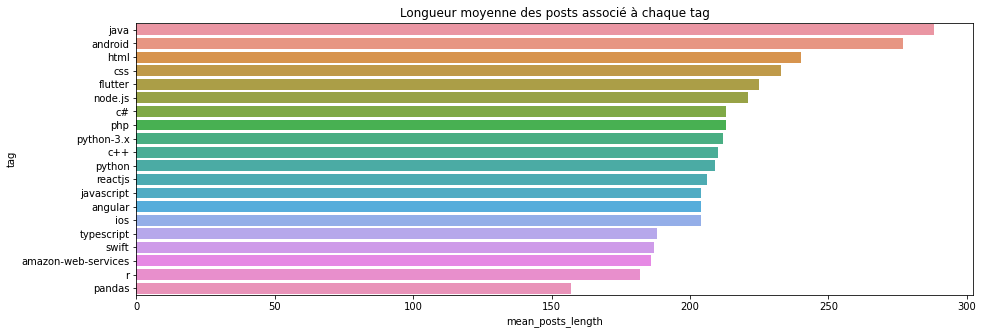

In [ ]:
mlb = MultiLabelBinarizer()
df_tmp_tmp = pd.DataFrame(data = mlb.fit_transform(data.tags.to_list()),
                          columns = mlb.classes_)

def contain_tag(x, tag):
  if tag in x:
    return x
  return np.nan 

tags = []
mean_posts_length = []

for tag in mlb.classes_:
    df_tmp = df.copy()
    df_tmp = df_tmp[df_tmp.tags.map(lambda x: contain_tag(x, tag)).isna() == False]
    
    tags.append(tag)
    mean_posts_length.append(int(df_tmp.post.map(len).mean()))
    
    
df_dist_tmp = pd.DataFrame(data = zip(tags, mean_posts_length),
                           columns = ["tag", "mean_posts_length"])
df_dist_tmp.sort_values(by = "mean_posts_length", ascending = False, inplace = True) 

plt.figure(figsize = (15, 5))
plt.title(f"Longueur moyenne des posts associé à chaque tag")
sns.barplot(data = df_dist_tmp,
            y = "tag",
            x = "mean_posts_length")
plt.show()

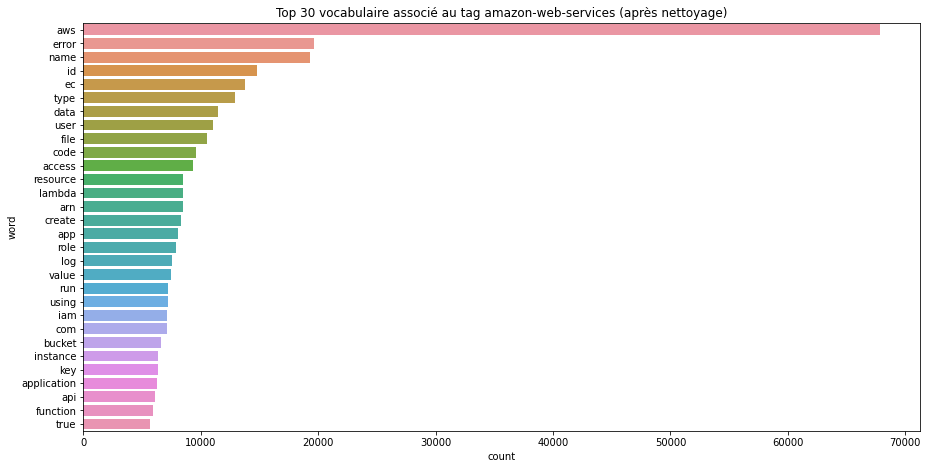

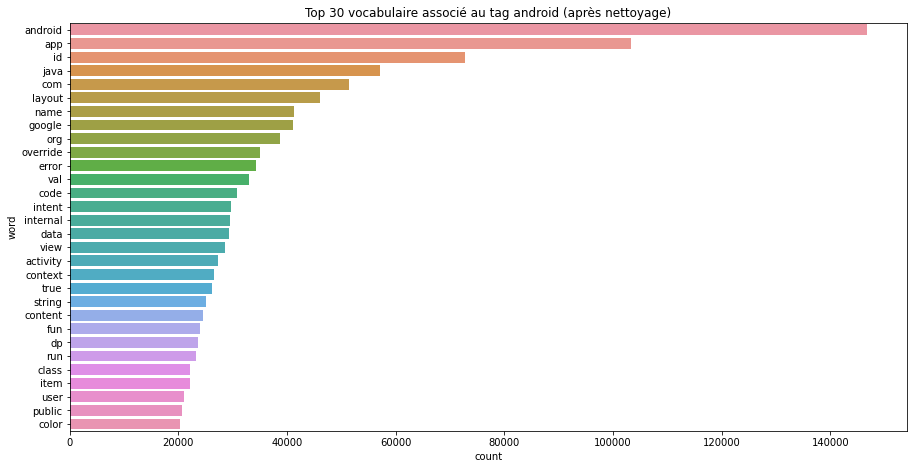

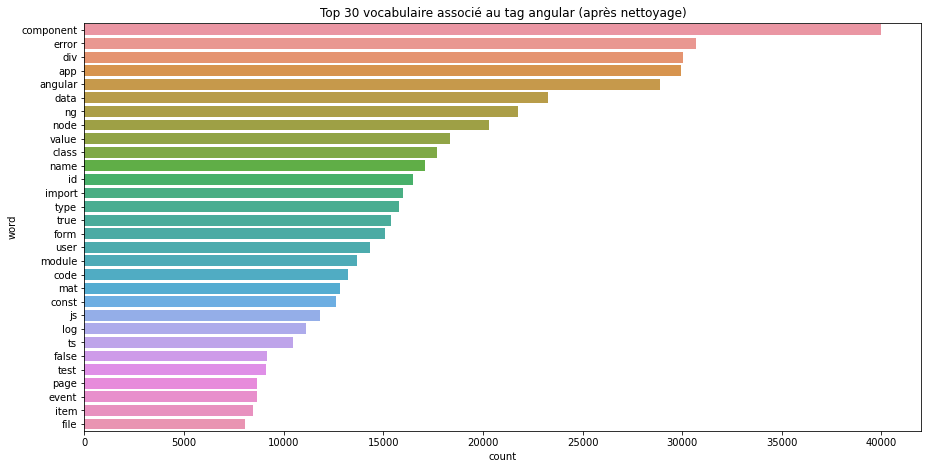

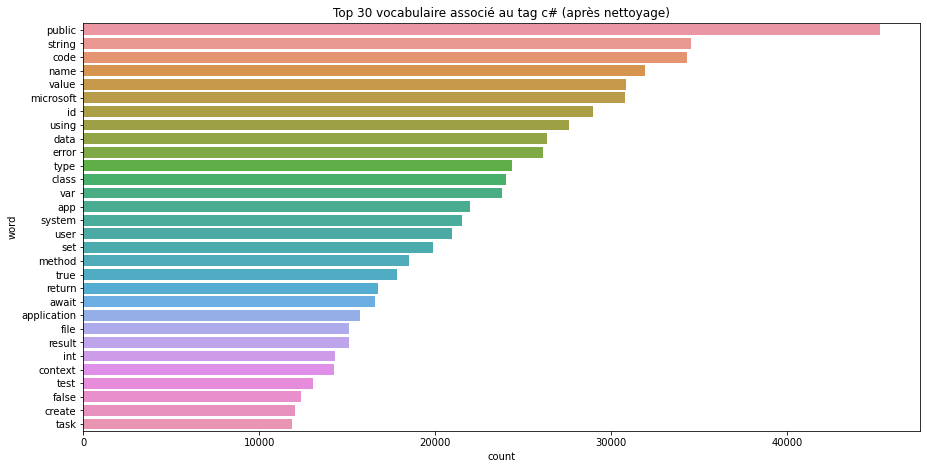

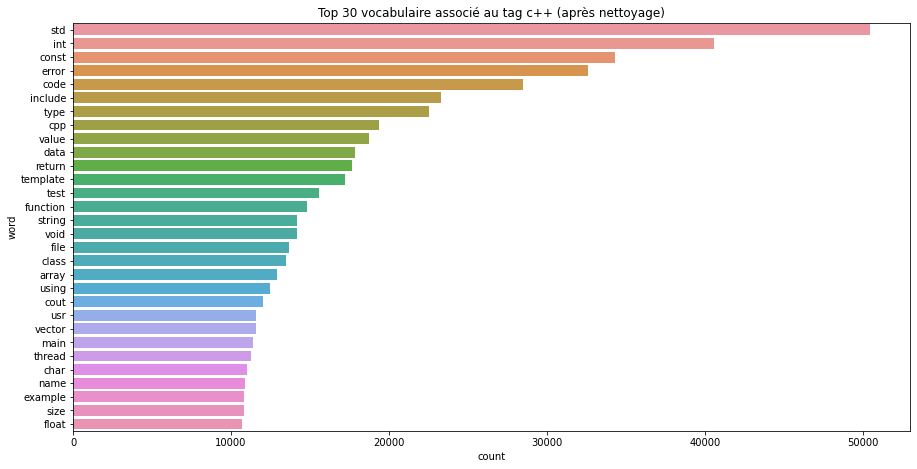

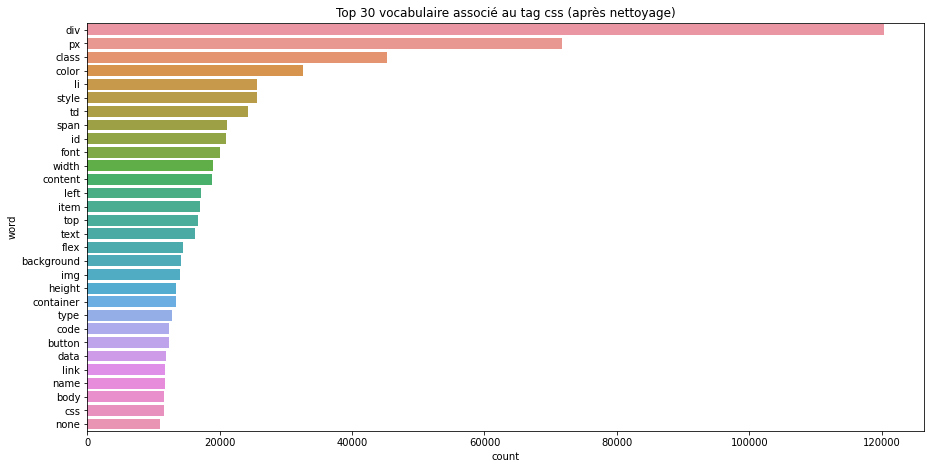

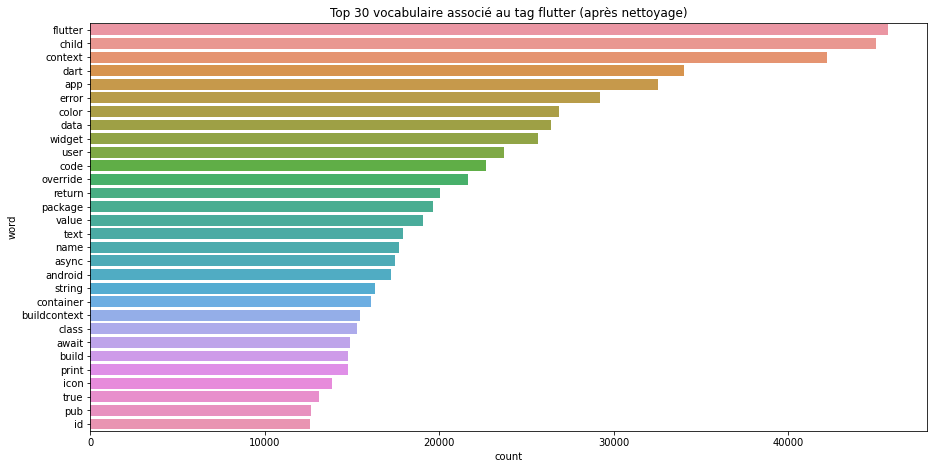

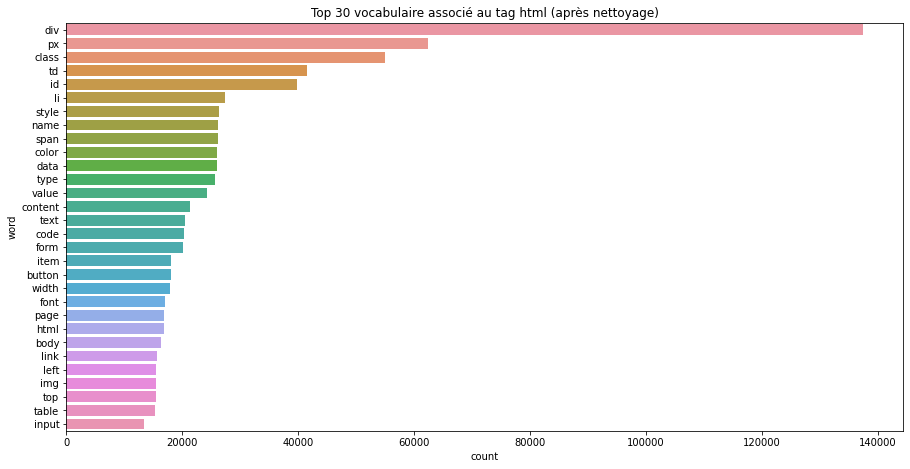

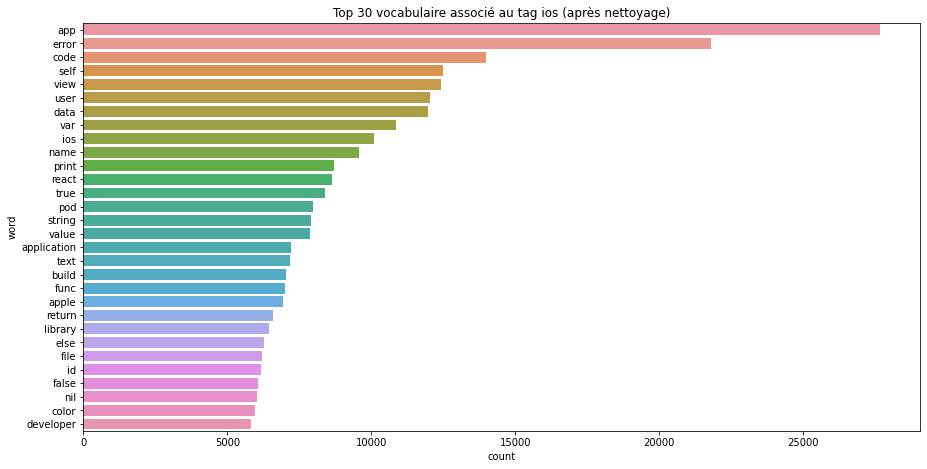

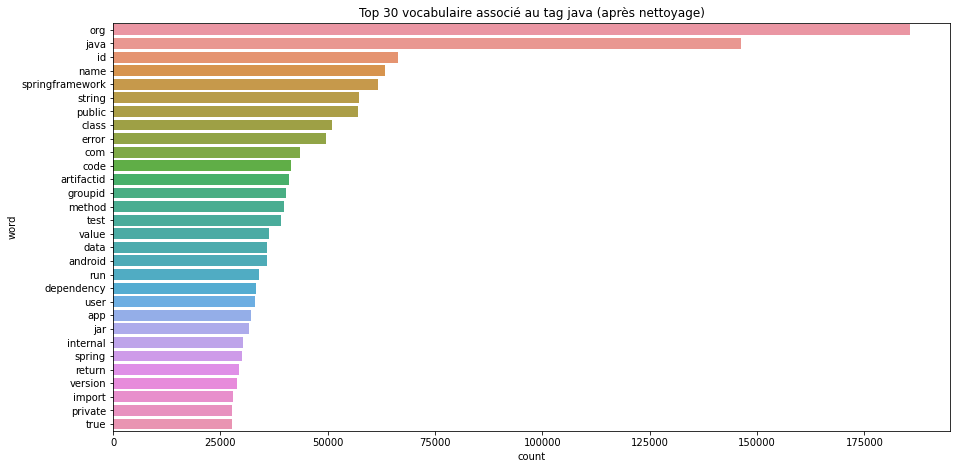

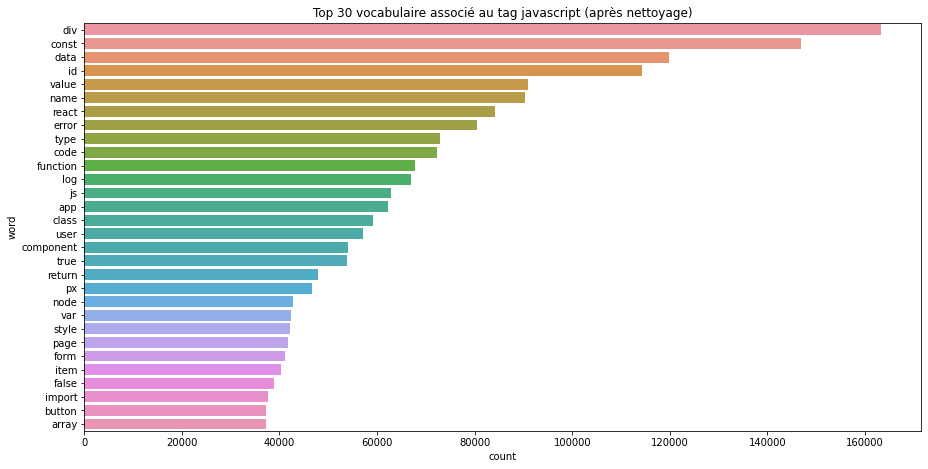

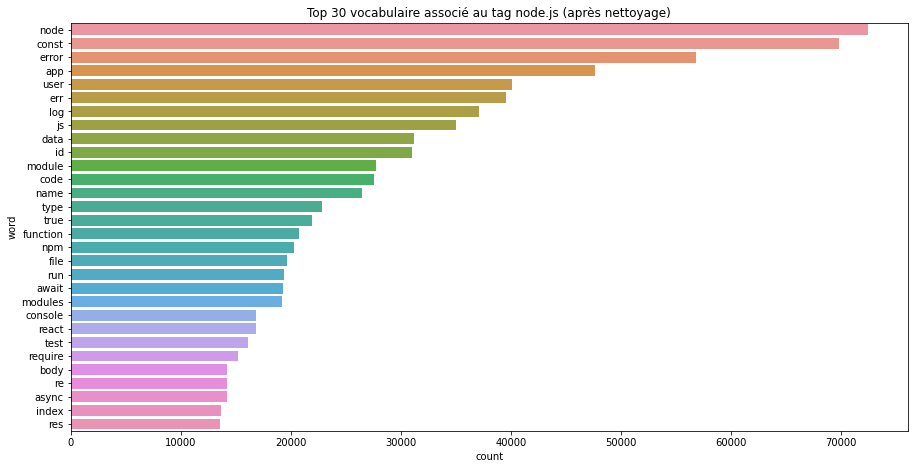

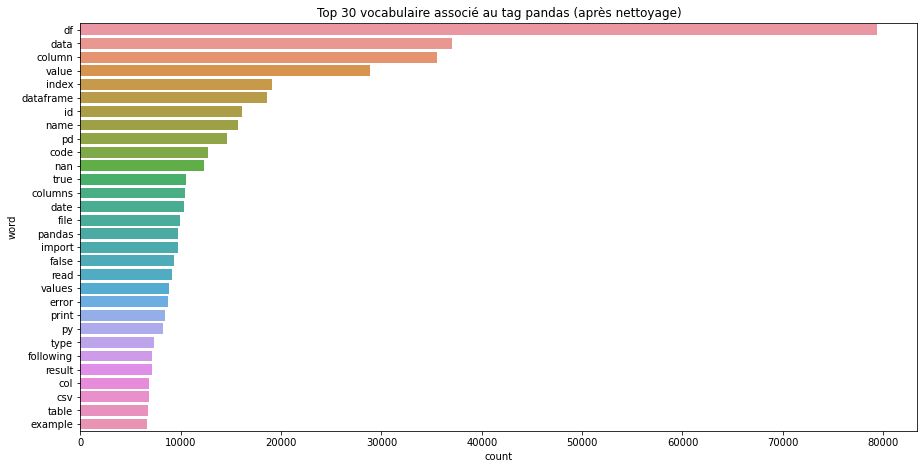

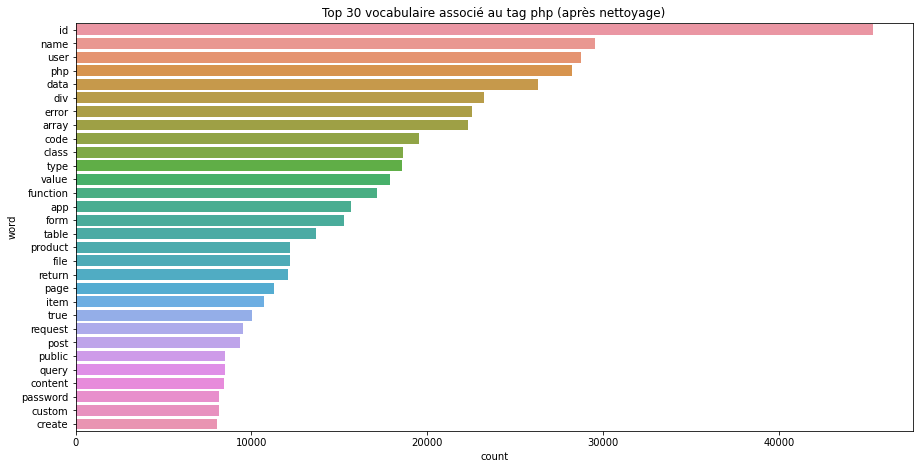

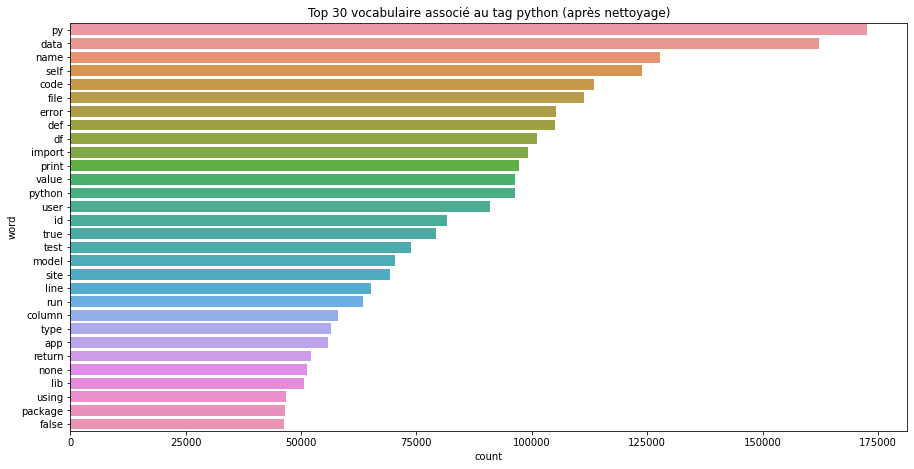

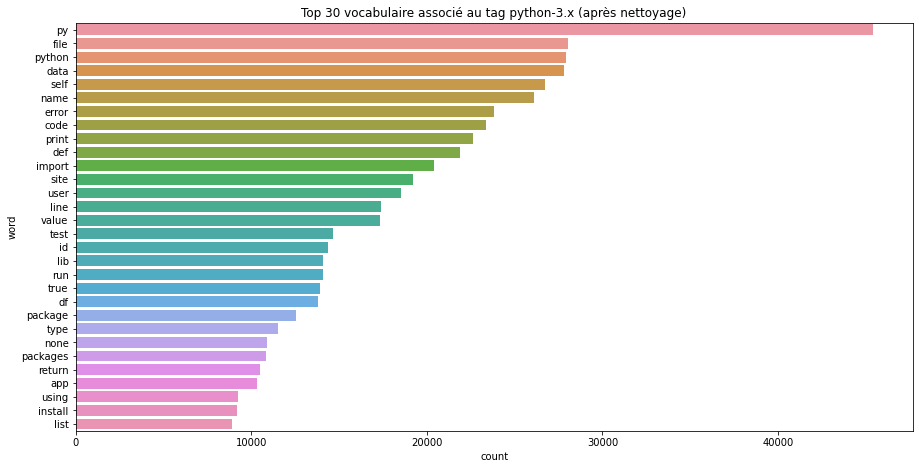

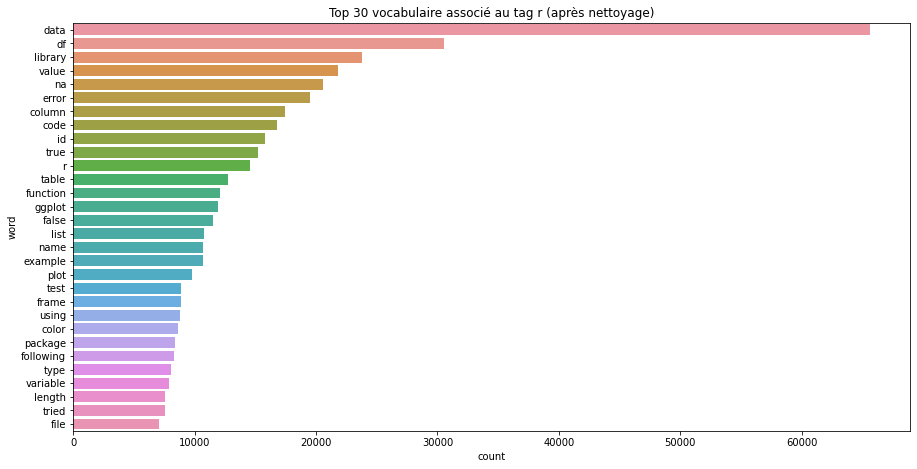

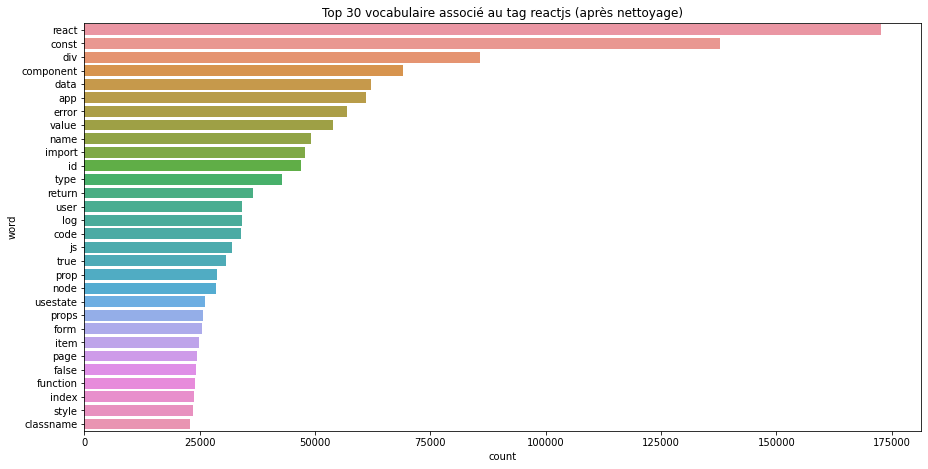

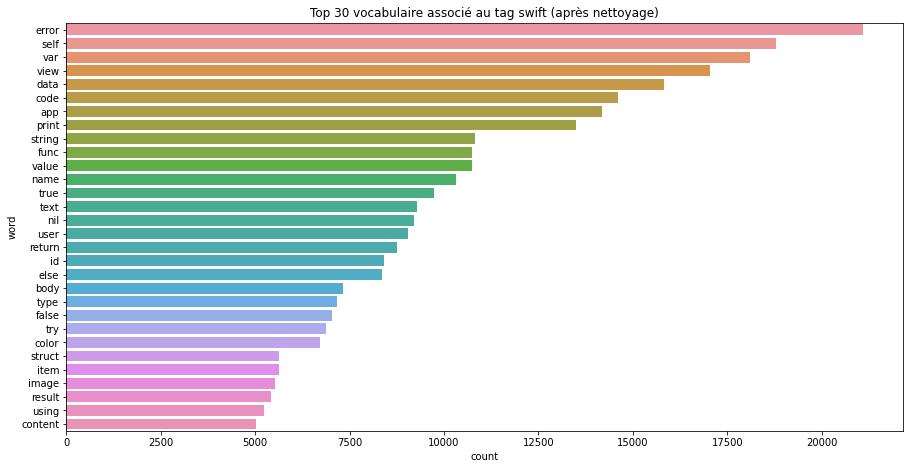

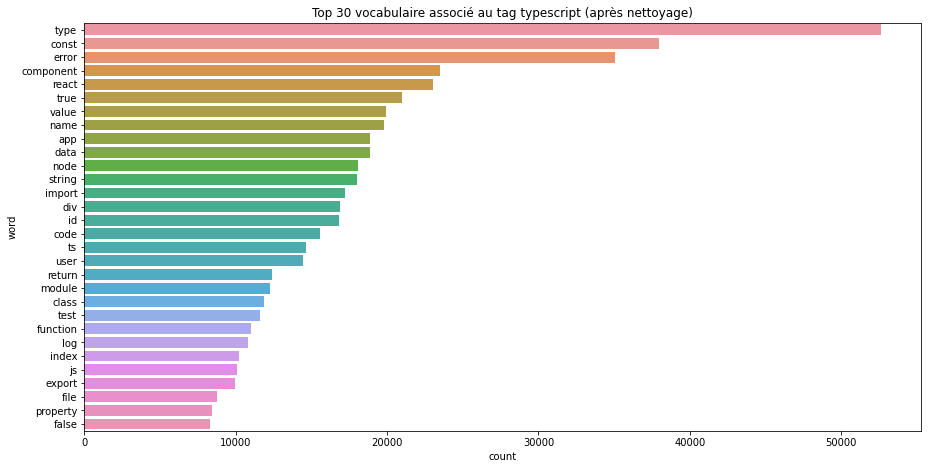

In [ ]:
mlb = MultiLabelBinarizer()
df_tmp_tmp = pd.DataFrame(data = mlb.fit_transform(df.tags.to_list()),
                          columns = mlb.classes_)

for tag in mlb.classes_.tolist():
    df_tmp = df.copy()
    df_tmp.loc[:, tag] = df_tmp_tmp[tag].values
    df_tmp = df_tmp[df_tmp[tag] == 1]
    all_words = [w for liste in df_tmp.post.map(lambda x: x.split()) for w in liste]
    words_dist = FreqDist(all_words).most_common(30)
    
    df_dist_tmp = pd.DataFrame(data = words_dist,
                       columns = ["word", "count"])
    
    plt.figure(figsize = (15, 7.5))
    plt.title(f"Top 30 vocabulaire associé au tag {tag} (après nettoyage)")
    sns.barplot(data = df_dist_tmp,
                y = "word",
                x = "count")
    plt.show()
    df_tmp.drop(columns = [tag], inplace = True)

On pousse l'analyse en redéfinissant des stopwords de la manière suivante:
si un mot apparaît dans le top 30 d'au moins la moitié des tags, on considérera qu'il n'apporte pas de détail spécifique au topic et on le supprime du vocabulaire.

In [ ]:
mlb = MultiLabelBinarizer()
df_tmp_tmp = pd.DataFrame(data = mlb.fit_transform(df.tags.to_list()),
                          columns = mlb.classes_)

words_top30_tag = []

for tag in mlb.classes_.tolist():
    df_tmp = df.copy()
    df_tmp.loc[:, tag] = df_tmp_tmp[tag].values
    df_tmp = df_tmp[df_tmp[tag] == 1]
    all_words = [w for liste in df_tmp.post.map(lambda x: x.split()) for w in liste]
    words_dist = FreqDist(all_words).most_common(30)
    words_dist = list(list(zip(*words_dist))[0])
    words_top30_tag.extend(words_dist)

new_stopwords = [x[0] for x in FreqDist(words_top30_tag).most_common() if x[1] >= len(mlb.classes_.tolist())/2]

In [ ]:
print(f"Nouveaux stopwords detectés:\n\n{new_stopwords}")

Nouveaux stopwords detectés:

['name', 'data', 'code', 'id', 'error', 'value', 'true', 'type', 'user', 'app', 'file', 'return', 'class', 'false']


On relance le TOP 30 mots par tag:

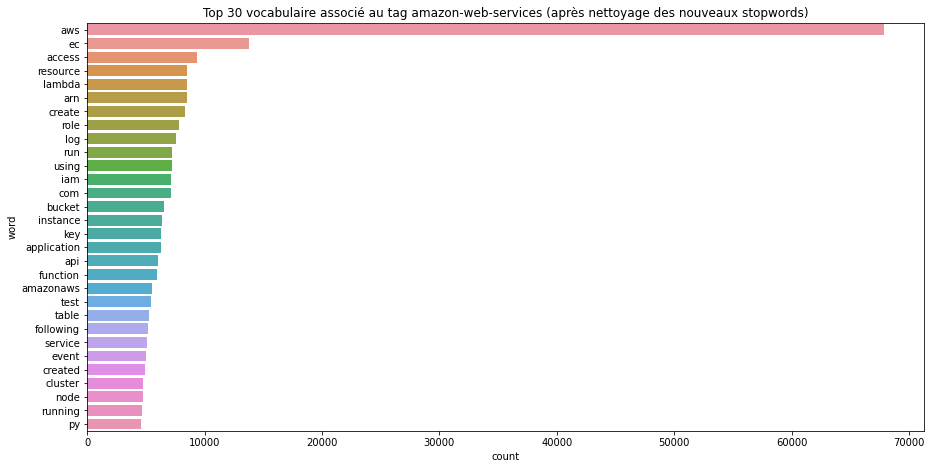

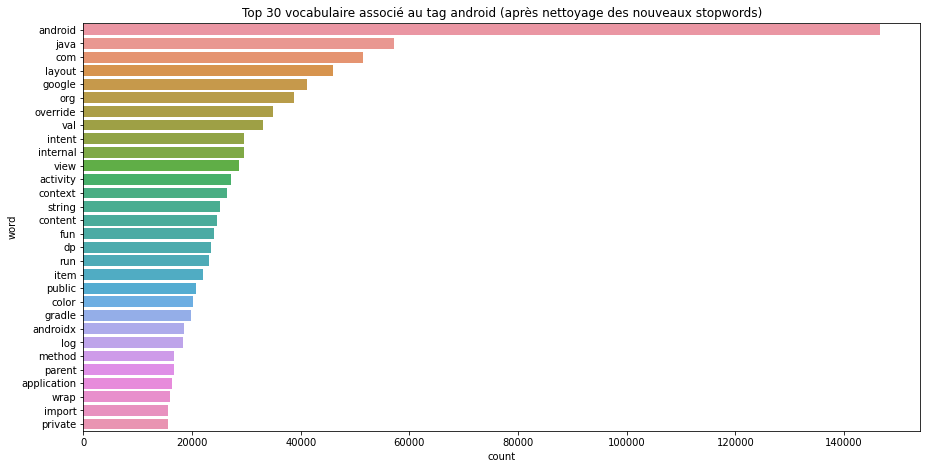

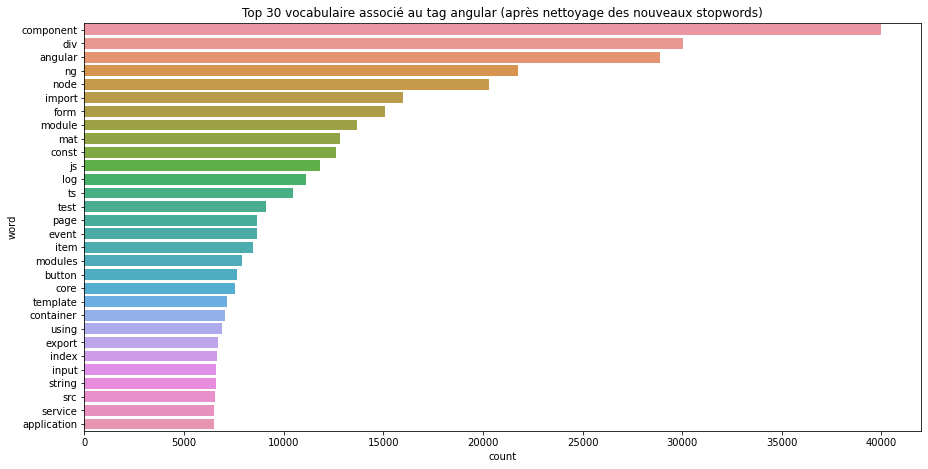

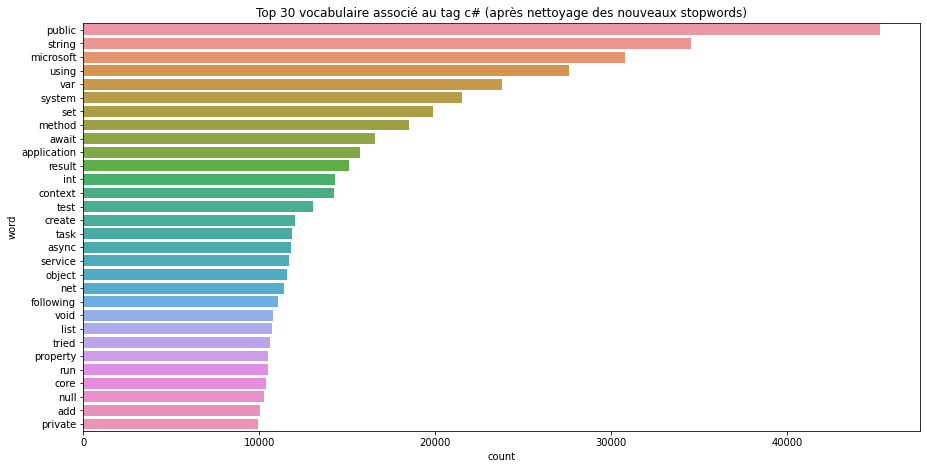

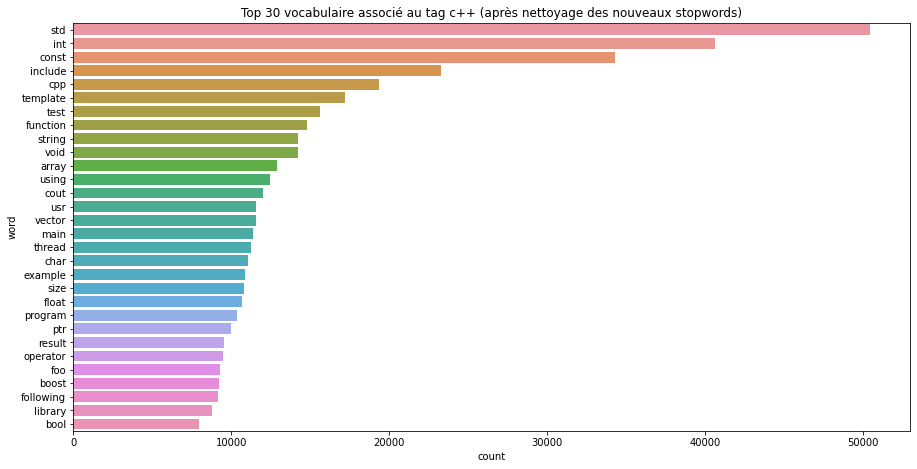

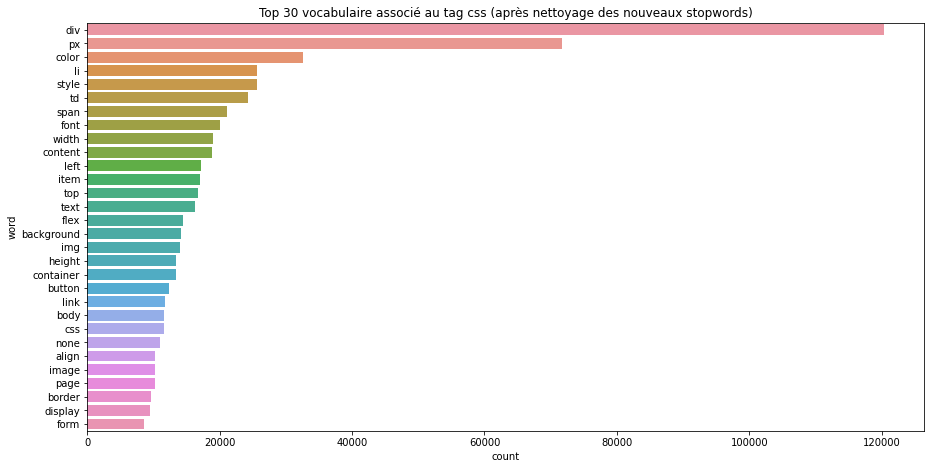

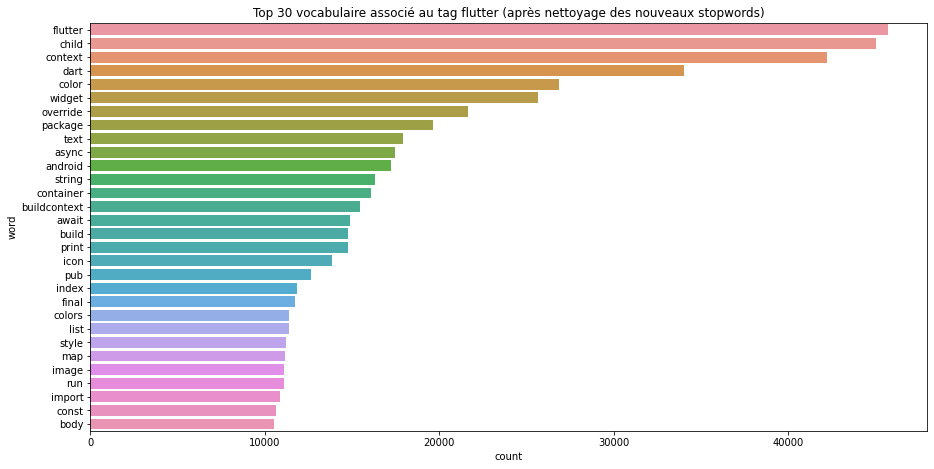

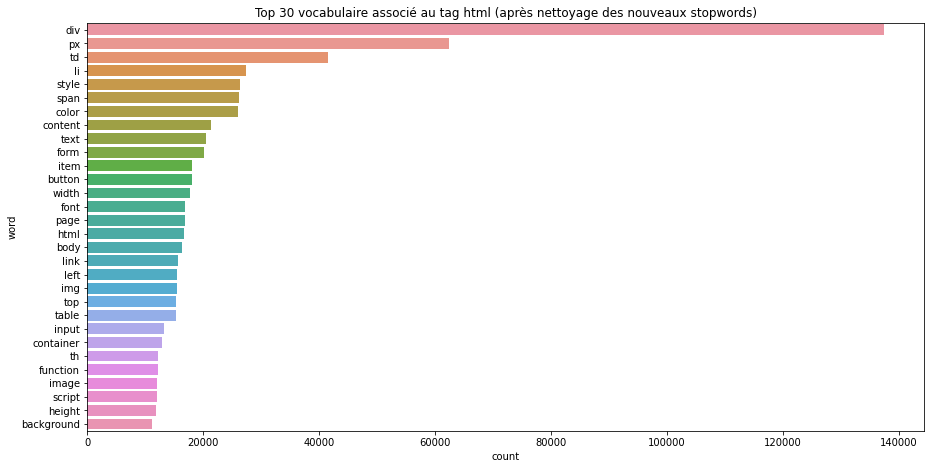

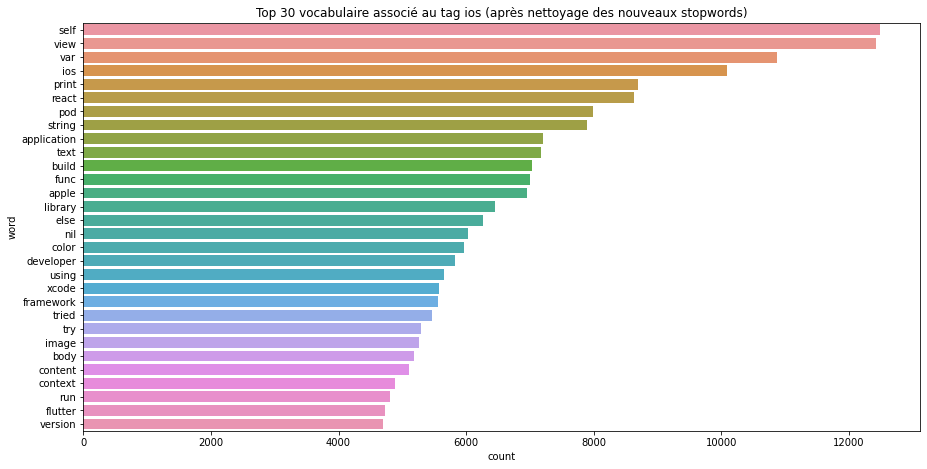

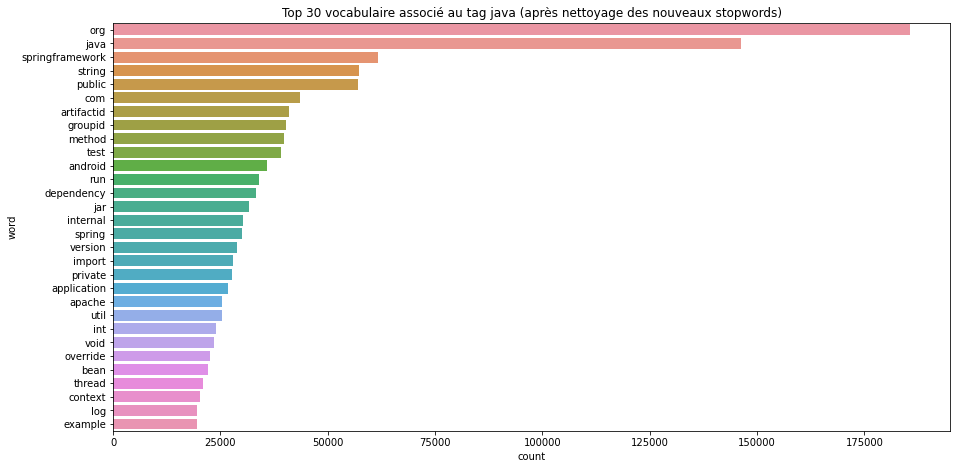

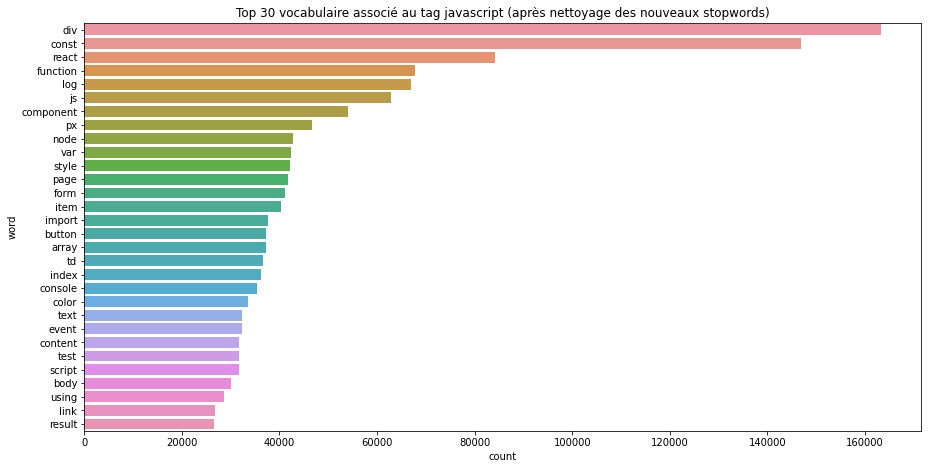

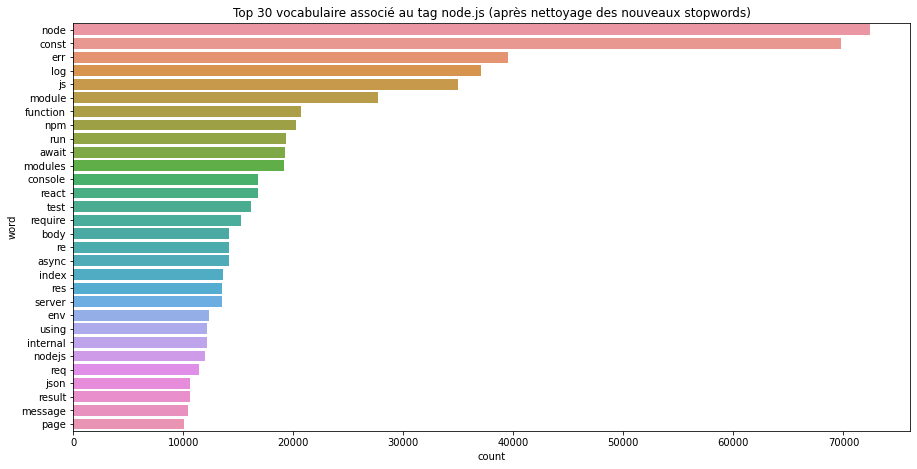

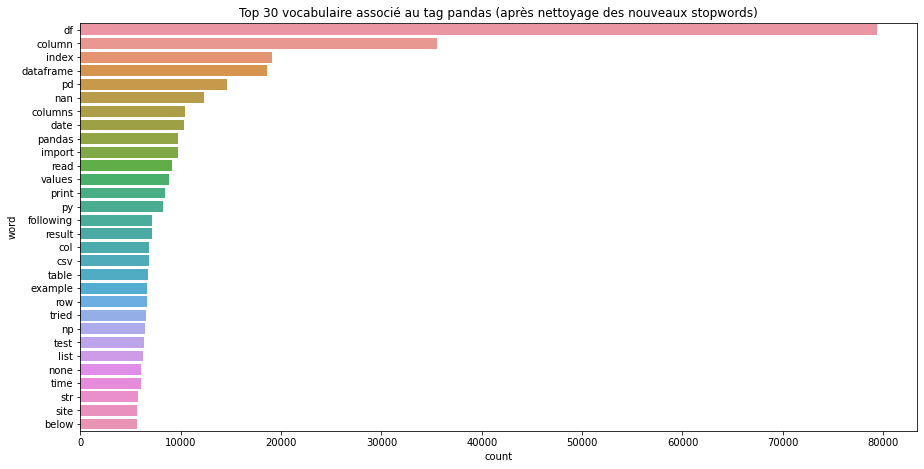

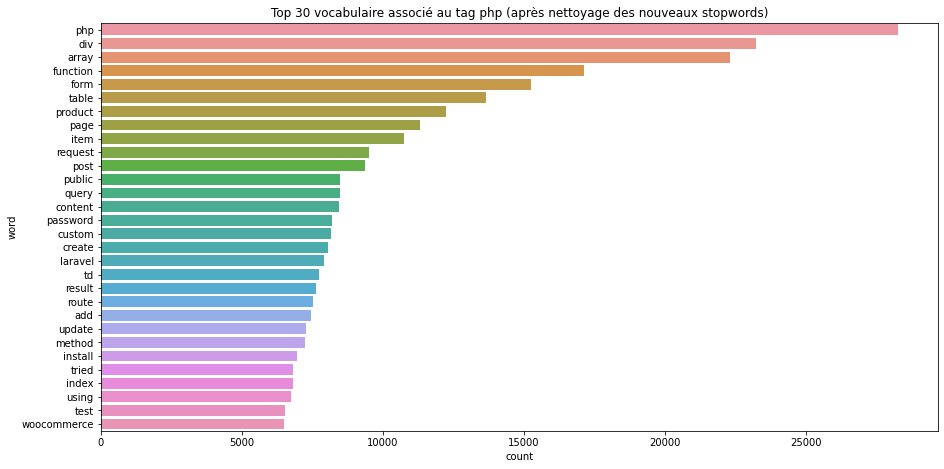

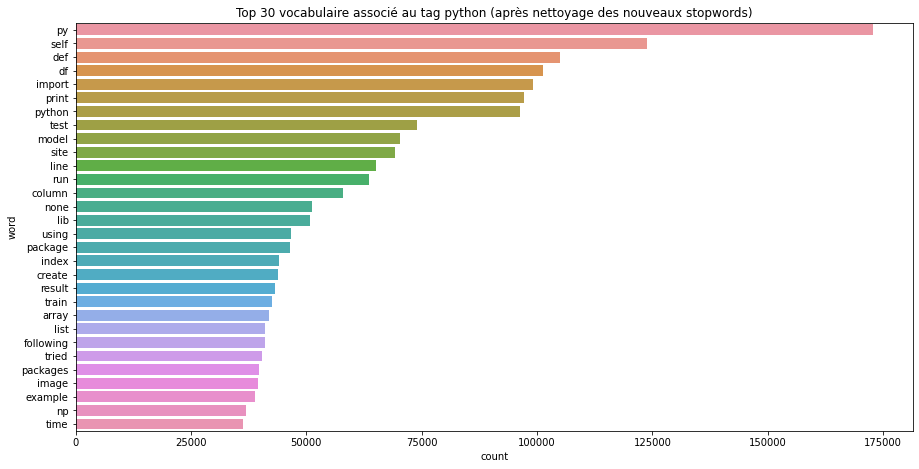

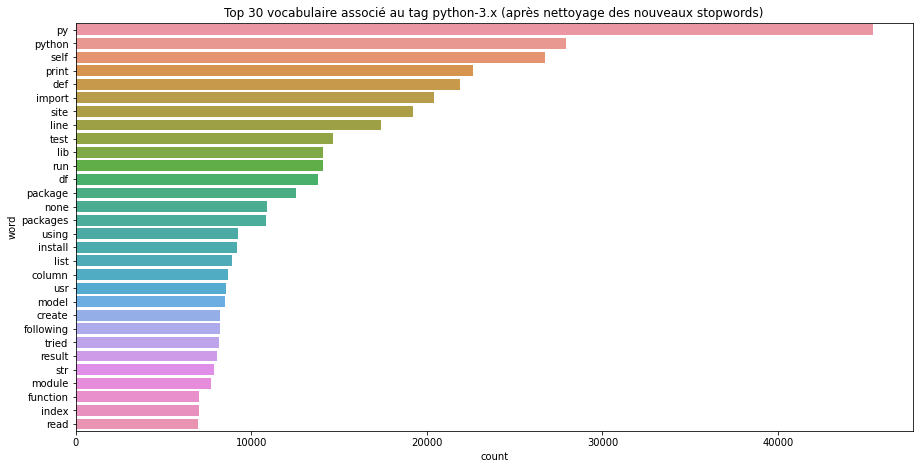

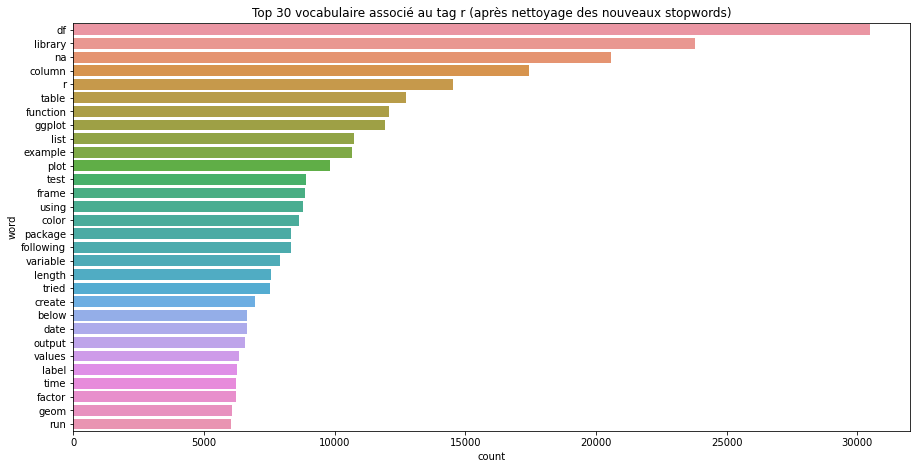

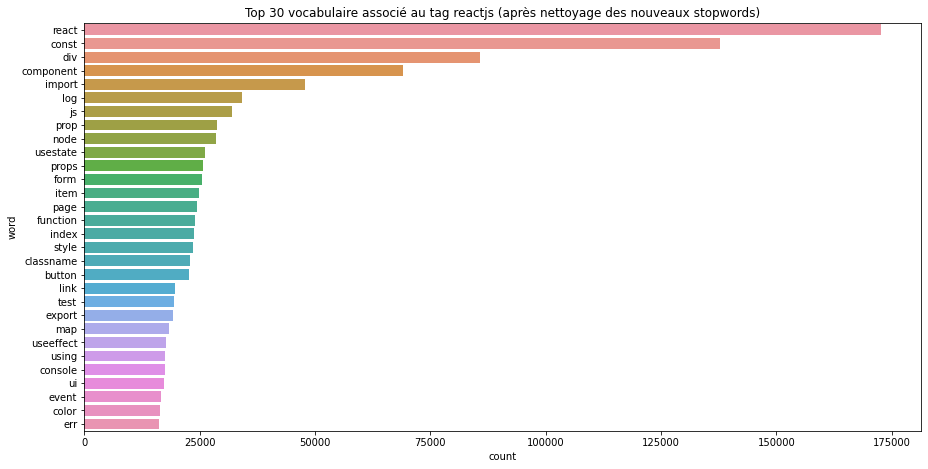

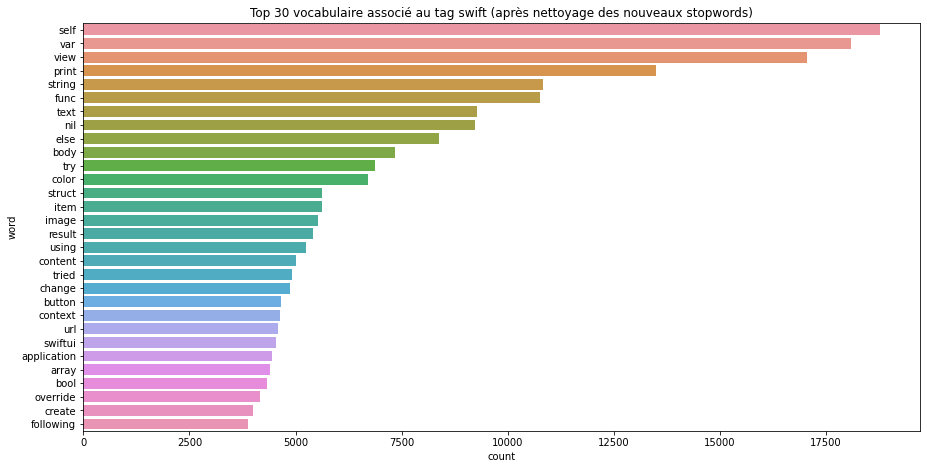

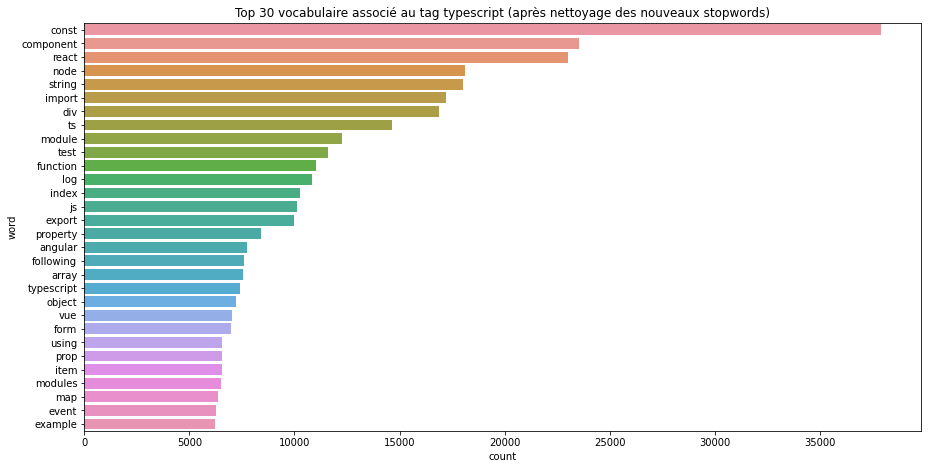

In [ ]:
mlb = MultiLabelBinarizer()
df_tmp_tmp = pd.DataFrame(data = mlb.fit_transform(df.tags.to_list()),
                          columns = mlb.classes_)

for tag in mlb.classes_.tolist():
    df_tmp = df.copy()
    df_tmp.loc[:, tag] = df_tmp_tmp[tag].values
    df_tmp = df_tmp[df_tmp[tag] == 1]
    all_words = [w for liste in df_tmp.post.map(lambda x: x.split()) for w in liste]
    words_dist = FreqDist(all_words).most_common(30)
    
    df_dist_tmp = pd.DataFrame(data = words_dist,
                       columns = ["word", "count"])
    
    plt.figure(figsize = (15, 7.5))
    plt.title(f"Top 30 vocabulaire associé au tag {tag} (après nettoyage des nouveaux stopwords)")
    sns.barplot(data = df_dist_tmp,
                y = "word",
                x = "count")
    plt.show()
    df_tmp.drop(columns = [tag], inplace = True)

Nous pourrions relancer cette analyse jusqu'à avoir des TOP 30 vocabulaire variés pour les différents tags.